In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Support Notebook :

1. https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
2. https://github.com/shijianjian/EfficientNet-PyTorch-3D
3. https://www.kaggle.com/davidbroberts/determining-mr-slice-orientation
4. 

In [ ]:
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

In [2]:
import os
import sys 
import glob
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
# from efficientnet_pytorch_3d import EfficientNet3D

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'

mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 128 #all the image sizes are of dim 256 x 256
NUM_IMAGES = 64

# 1. EDA 

In [4]:
#number of train & test samples
print(f"Number of Sample in Train Data : {len(glob.glob(f'{data_directory}/train/*'))}")
print(f"Number of Sample in Test Data : {len(glob.glob(f'{data_directory}/test/*'))}")

Number of Sample in Train Data : 585
Number of Sample in Test Data : 87


In [55]:
train_labels = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
train_labels.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [6]:
train_labels['MGMT_value'].value_counts()

1    307
0    278
Name: MGMT_value, dtype: int64

## 1.1 Understanding a single SCAN file

In [7]:
def center_crop(img, dim):
    'Center crop'
    
    width, height = img.shape[1], img.shape[0]
    #process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0]
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img


In [8]:
#load dicom image
#image size will be 128x128
def load_dicom_image(file_path, img_size = SIZE, voi_lut = True) :
    
    dicom = pydicom.read_file(file_path)
    data = dicom.pixel_array
    if voi_lut :
        data = apply_voi_lut(data, dicom)
        
    data = center_crop(data, (128,128))
    return data

In [9]:
#load a single image
split = 'train'
scan_id = '00002'
mri_type = 'FLAIR'
#glob will store files present in the provided path as per the pattern
files = sorted(glob.glob(f"{data_directory}/train/00002/FLAIR/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

print(f'Number of dcm files : {len(files)}')
print(files[:5])

Number of dcm files : 129
['../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00002/FLAIR/Image-387.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00002/FLAIR/Image-388.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00002/FLAIR/Image-389.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00002/FLAIR/Image-390.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00002/FLAIR/Image-391.dcm']


The above scan file contains 129 dcm files for the FLAIR MRI type. Different scan files can contains different number of scan files. Below, we will try to plot the distribution of the number of files for each type of MRI

25th Percentile : 60.0
50th Percentile : 60.0
75th Percentile : 200.0


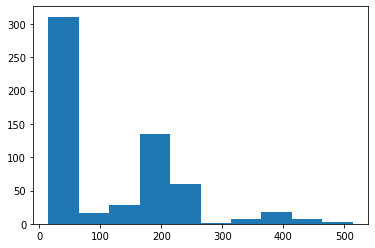

In [10]:
#FOR FLAIR
scan_id_list = [str(x).rjust(5,'0') for x in train_labels['BraTS21ID'].tolist()]
num_of_dcm_files = [len(glob.glob(f"{data_directory}/train/{scan_id}/FLAIR/*.dcm")) for scan_id in scan_id_list]
num_of_dcm_files = np.array(num_of_dcm_files)

#print percentiles
print(f'25th Percentile : {np.percentile(num_of_dcm_files, 25)}')
print(f'50th Percentile : {np.percentile(num_of_dcm_files, 50)}')
print(f'75th Percentile : {np.percentile(num_of_dcm_files, 75)}')
plt.hist(num_of_dcm_files)
plt.show()

25th Percentile : 32.0
50th Percentile : 180.0
75th Percentile : 192.0


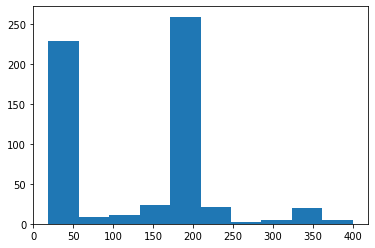

In [11]:
#FOR T1W
scan_id_list = [str(x).rjust(5,'0') for x in train_labels['BraTS21ID'].tolist()]
num_of_dcm_files = [len(glob.glob(f"{data_directory}/train/{scan_id}/T1w/*.dcm")) for scan_id in scan_id_list]
num_of_dcm_files = np.array(num_of_dcm_files)

#print percentiles
print(f'25th Percentile : {np.percentile(num_of_dcm_files, 25)}')
print(f'50th Percentile : {np.percentile(num_of_dcm_files, 50)}')
print(f'75th Percentile : {np.percentile(num_of_dcm_files, 75)}')
plt.hist(num_of_dcm_files)
plt.show()

25th Percentile : 129.0
50th Percentile : 192.0
75th Percentile : 192.0


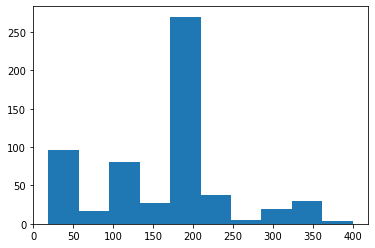

In [12]:
#FOR T1wCE
scan_id_list = [str(x).rjust(5,'0') for x in train_labels['BraTS21ID'].tolist()]
num_of_dcm_files = [len(glob.glob(f"{data_directory}/train/{scan_id}/T1wCE/*.dcm")) for scan_id in scan_id_list]
num_of_dcm_files = np.array(num_of_dcm_files)

#print percentiles
print(f'25th Percentile : {np.percentile(num_of_dcm_files, 25)}')
print(f'50th Percentile : {np.percentile(num_of_dcm_files, 50)}')
print(f'75th Percentile : {np.percentile(num_of_dcm_files, 75)}')
plt.hist(num_of_dcm_files)
plt.show()

25th Percentile : 64.0
50th Percentile : 64.0
75th Percentile : 376.0


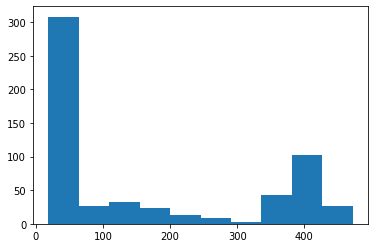

In [13]:
#FOR T2w
scan_id_list = [str(x).rjust(5,'0') for x in train_labels['BraTS21ID'].tolist()]
num_of_dcm_files = [len(glob.glob(f"{data_directory}/train/{scan_id}/T2w/*.dcm")) for scan_id in scan_id_list]
num_of_dcm_files = np.array(num_of_dcm_files)

#print percentiles
print(f'25th Percentile : {np.percentile(num_of_dcm_files, 25)}')
print(f'50th Percentile : {np.percentile(num_of_dcm_files, 50)}')
print(f'75th Percentile : {np.percentile(num_of_dcm_files, 75)}')
plt.hist(num_of_dcm_files)
plt.show()

In [14]:
'''
Here, we are taking middle 64 images from the dicom files. The idea is to capture the middle section of brain and 
making the channels constant for all the files
'''
middle = len(files)//2
num_imgs2 = 64//2
p1 = max(0, middle - num_imgs2)
p2 = min(len(files), middle + num_imgs2)
img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]]).T 
print(img3d.shape)

(128, 128, 64)


In [15]:
#padding it with zero dim if channel dimension is less than 64
if img3d.shape[-1] < 64:
    n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
    img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
#min max scaling
if np.min(img3d) < np.max(img3d):
    img3d = img3d - np.min(img3d)
    img3d = img3d / np.max(img3d)
 
  
img3d = np.expand_dims(img3d,0) #to add the batch dimension
print(img3d.shape)
img3d[:,:,1]      

(1, 128, 128, 64)


array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.43211369, 0.52489683, 0.49331141, ..., 0.29574923,
         0.16097188, 0.        ],
        [0.43407963, 0.52131527, 0.48755739, ..., 0.27772573,
         0.14918354, 0.        ],
        [0.43250688, 0.51455011, 0.48679019, ..., 0.27076211,
         0.09186779, 0.        ]]])

In [16]:
'''
Putting everything in a single function
'''
def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, 
                         img_size=SIZE, mri_type="FLAIR", 
                         split="train"):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
        
    img3d = np.expand_dims(img3d,0)
    img3d = np.transpose(img3d, (0,3,1,2))
            
    return img3d

a = load_dicom_images_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 64, 128, 128)
0.0 1.0 0.3412781428862095 0.3668791707614164


## Train & Test Split

In [17]:
def set_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(12)

In [56]:
df_train, df_valid = train_test_split(
    train_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_labels["MGMT_value"],
)

print(df_train.shape, df_valid.shape)

(468, 2) (117, 2)


## Model and Training Class

In [19]:
from torch.utils.data import Dataset, DataLoader

In [20]:
class MRIScanDataset(Dataset) :
    
    def __init__(self, paths, targets=None, mri_type=None, 
                 label_smoothing=0.01, split="train", augment=False) :
        
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
        
        
    def __len__(self) :
        return len(self.paths)
    
    def __getitem__(self, index) :
        
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index],
                                        split=self.split)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0
                
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], 
                                        split="train")
            
            
        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}
               

In [21]:
# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
#         n_features = self.net._fc.in_features
#         self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
#     def forward(self, x):
#         out = self.net(x)
#         return out

In [22]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(1, 16)
        self.conv_layer2 = self._conv_layer_set(16, 32)
        self.fc1 = nn.Linear(14*30*30*32, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(64)
        self.drop=nn.Dropout(p=0.15)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

In [26]:
class TrainModel:
    
    def __init__(self, model, device, 
                optimizer, criterion ):
        
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        
        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_dataloader, valid_dataloader, save_path, patience):
        
        start_time = time.time()
        
        for epoch in range(1, epochs + 1):
            
            print(f'Running Epoch {epoch}...................')
            
            train_loss, train_auc = self.train(train_dataloader)
            val_loss, val_auc = self.validation(valid_dataloader)
            
            print(f'For Epoch {epoch :>7d} Train Loss {train_loss : >5f} Train AUC {train_auc} Val Loss {val_loss} Val AUC {val_auc} ')
            print(f'For Epoch {epoch :>7d} Time Taken {(time.time() - start_time)/60}')
            
            
            if self.best_valid_score > val_loss: 
                
                self.save_model(epoch, save_path, val_loss, val_auc)
                print(f'AUC Improved from {self.best_valid_score :4f} to {val_loss}. Saved model to {self.lastmodel}')
                
                #updating the lossed
                self.best_valid_score = val_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                print(f"\nValid auc didn't improve last {patience} epochs.")
                break
            
            
            
    def train(self, train_dataloader) :
        '''
        For Training the model.
        We will be calculating batch wise loss and 
        finally calcualting auc on the overall y
        '''
    
        self.model.train()
        sum_loss = 0
        y_all = []
        output_all = []
        start_time = time.time()

        for batch, data in enumerate(train_dataloader) :

            X = data['X'].to(self.device)
            y = data['y'].to(self.device)

            self.optimizer.zero_grad()     #clearning the accumulated gradients
            pred = self.model(X).squeeze(1)           #make the prediction
            loss = self.criterion(pred, y) #calcualte the loss
            loss.backward()           #backpropagation
            self.optimizer.step()          #update weights

            sum_loss += loss.detach().item()
            y_all.extend(data['y'].tolist()) #save all y values to y_val
            output_all.extend(torch.sigmoid(pred).tolist())  #save all pred to output all

            #print peformance
            if batch % 5 == 0 :
                time_taken = (time.time() - start_time)
                start_time = time.time()
                print(f'Train Batch {batch + 1 :>7d} Loss : {sum_loss/(batch +1)} Time Taken : {time_taken/60} ')

        y_all = [1 if x > 0.5 else 0 for x in y_all]
        train_auc = roc_auc_score(y_all, output_all)

        return sum_loss/len(train_dataloader) , train_auc
    
    
    
    def validation(self, val_dataloader) :
    
        self.model.eval()
        sum_loss = 0
        y_all = []
        output_all = []

        for batch, data in enumerate(val_dataloader) :

            with torch.no_grad() :

                X_val = data['X'].to(self.device)
                y_val = data['y'].to(self.device)

                pred = self.model(X_val).squeeze(1)   #make the prediction
                loss = self.criterion(pred, y_val) #calcualte the loss

                sum_loss += loss.detach().item()
                y_all.extend(data['y'].tolist()) #save all y values to y_val
                output_all.extend(torch.sigmoid(pred).tolist())  #save all pred to output all

                #print peformance
                if batch % 5 == 0 :
                    print(f'Test Batch {batch + 1 :>7d} Loss : {sum_loss/(batch +1)}')

        y_all = [1 if x > 0.5 else 0 for x in y_all]
        val_auc = roc_auc_score(y_all, output_all)

        return sum_loss/len(val_dataloader) , val_auc

            
    def save_model(self, n_epoch, save_path, loss, auc):
        
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )

In [27]:
# df_train.loc[:,"MRI_Type"] = 'FLAIR'
# train_dataset = MRIScanDataset(
#         df_train["BraTS21ID"].values, 
#         df_train["MGMT_value"].values, 
#         df_train["MRI_Type"].values,
#         augment=False)

# train_loader = DataLoader(
#         train_dataset,
#         batch_size=16,
#         shuffle=True,
#         num_workers=8,pin_memory = True )


# for data in train_loader :
#     X1 = data['X']
#     y1 = data['y']
#     print(X1.shape)
#     print(y1.shape)
#     break

In [66]:
#train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def train_mri_type(df_train, df_valid, mri_type):
    
    #creating data based on selected mri_type
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
        
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    #train dataset
    train_dataset = MRIScanDataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values,
        augment=False)
    
    #valid dataset
    valid_dataset = MRIScanDataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values)
    
    #train dataloader
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=8,pin_memory = True )

    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=4,
        shuffle=False,
        num_workers=8,pin_memory = True
    )
    
    #load model
    model = CNNModel()
    model.to(device)
    
    #define optimizer & criterion
    criterion = F.binary_cross_entropy_with_logits
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    

    trainer = TrainModel(model, device, 
                    optimizer,criterion)

    history = trainer.fit(epochs= 5, train_dataloader= train_loader, valid_dataloader= valid_loader, save_path= f"{mri_type}", patience= 5)
    
    return trainer.lastmodel


cpu


In [57]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in ['T2w']]
    print(modelfiles)

(468, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,T2w
161,240,1,T2w
508,740,1,T2w
495,725,1,T2w
298,432,0,T2w


Running Epoch 1...................
Train Batch       1 Loss : 0.6563823819160461 Time Taken : 0.18688934644063313 
Train Batch       6 Loss : 0.8759249349435171 Time Taken : 0.22840533256530762 
Train Batch      11 Loss : 0.8175291771238501 Time Taken : 0.23779894908269247 
Train Batch      16 Loss : 0.7811290267854929 Time Taken : 0.22878638903299967 
Train Batch      21 Loss : 0.7521119302227384 Time Taken : 0.23124816020329794 
Train Batch      26 Loss : 0.7959985584020615 Time Taken : 0.22467987140019735 
Train Batch      31 Loss : 0.77107187336491 Time Taken : 0.2261155366897583 
Train Batch      36 Loss : 0.7713348178399934 Time Taken : 0.2260476549466451 
Train Batch      41 Loss : 0.7739777281516935 Time Taken : 0.2232532540957133 
Train Batch      46 Loss : 0.7777410518863926 Time Taken : 0.22376630703608194 
Train Batch      51 Loss : 0.7653867783499699 Time Taken : 0.22585370937983196 
Train Batch      56 Loss : 0.7562201124216829 Time Taken : 0.23823639551798503 
Train Batc

In [67]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in ['FLAIR']]
    print(modelfiles)

(468, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,FLAIR
161,240,1,FLAIR
508,740,1,FLAIR
495,725,1,FLAIR
298,432,0,FLAIR


Running Epoch 1...................
Train Batch       1 Loss : 0.71163409948349 Time Taken : 0.1697358767191569 
Train Batch       6 Loss : 1.0110363513231277 Time Taken : 0.23709946473439533 
Train Batch      11 Loss : 0.9293274473060261 Time Taken : 0.22152148087819418 
Train Batch      16 Loss : 0.8434413988143206 Time Taken : 0.22093075911204021 
Train Batch      21 Loss : 0.8398713795911699 Time Taken : 0.2208802580833435 
Train Batch      26 Loss : 0.8245215289867841 Time Taken : 0.22490954001744587 
Train Batch      31 Loss : 0.8067611926986326 Time Taken : 0.21855865319569906 
Train Batch      36 Loss : 0.7998089186019368 Time Taken : 0.2229761282602946 
Train Batch      41 Loss : 0.7967976629734039 Time Taken : 0.21913760503133137 
Train Batch      46 Loss : 0.7871002483627071 Time Taken : 0.22480460007985434 
Train Batch      51 Loss : 0.7774776962457919 Time Taken : 0.2247634808222453 
Train Batch      56 Loss : 0.7787573193865163 Time Taken : 0.21523717641830445 
Train Batch

In [29]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in ['T1wCE']]
    print(modelfiles)

(468, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,T1wCE
161,240,1,T1wCE
508,740,1,T1wCE
495,725,1,T1wCE
298,432,0,T1wCE


Running Epoch 1...................
Train Batch       1 Loss : 0.7916409373283386 Time Taken : 0.16586863199869792 
Train Batch       6 Loss : 1.0633291006088257 Time Taken : 0.21725447177886964 
Train Batch      11 Loss : 1.037536539814689 Time Taken : 0.20504048268000286 
Train Batch      16 Loss : 1.0796618275344372 Time Taken : 0.21703360478083292 
Train Batch      21 Loss : 1.0720351082938058 Time Taken : 0.20683375199635823 
Train Batch      26 Loss : 1.0356693749244397 Time Taken : 0.21170257329940795 
Train Batch      31 Loss : 1.0021603876544583 Time Taken : 0.21460738976796467 
Train Batch      36 Loss : 0.9467438343498442 Time Taken : 0.2124841809272766 
Train Batch      41 Loss : 0.9174312425822746 Time Taken : 0.2143505573272705 
Train Batch      46 Loss : 0.8986812156179677 Time Taken : 0.21102457046508788 
Train Batch      51 Loss : 0.8799707644125995 Time Taken : 0.2090568423271179 
Train Batch      56 Loss : 0.8640023767948151 Time Taken : 0.21327878634134928 
Train Bat

In [31]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in ['T1w']]
    print(modelfiles)

(468, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,T1w
161,240,1,T1w
508,740,1,T1w
495,725,1,T1w
298,432,0,T1w


Running Epoch 1...................
Train Batch       1 Loss : 0.602473795413971 Time Taken : 0.14525330861409505 
Train Batch       6 Loss : 0.6718316972255707 Time Taken : 0.22649770180384318 
Train Batch      11 Loss : 0.8280773758888245 Time Taken : 0.2129115343093872 
Train Batch      16 Loss : 0.7965491265058517 Time Taken : 0.21849509477615356 
Train Batch      21 Loss : 0.7694494639124189 Time Taken : 0.22142302989959717 
Train Batch      26 Loss : 0.763761735879458 Time Taken : 0.2125857671101888 
Train Batch      31 Loss : 0.7563709597433766 Time Taken : 0.2164621313412984 
Train Batch      36 Loss : 0.7607561498880386 Time Taken : 0.2196936011314392 
Train Batch      41 Loss : 0.7585284768081293 Time Taken : 0.21788819630940756 
Train Batch      46 Loss : 0.7446494750354601 Time Taken : 0.21289621988932292 
Train Batch      51 Loss : 0.7366472354122237 Time Taken : 0.20841342210769653 
Train Batch      56 Loss : 0.7359764501452446 Time Taken : 0.2207354744275411 
Train Batch 

## Prediction

In [71]:
def predict(modelfile, df, mri_type, split):
    
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    
    data_retriever = MRIScanDataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = CNNModel()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

In [72]:
model_files = ['./FLAIR-e1-loss0.661-auc0.647.pth', 
              './T1w-e8-loss0.669-auc0.609.pth',
              './T1wCE-e3-loss0.699-auc0.505.pth',
              './T2w-e4-loss0.644-auc0.696.pth']

mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
df_valid = df_valid.set_index("BraTS21ID")

for m, mtype in zip(model_files,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid[f"MGMT_pred_{mtype}"] = pred
    
df_valid.head()

Predict: ./FLAIR-e1-loss0.661-auc0.647.pth FLAIR (117, 2)
Predict: ./T1w-e8-loss0.669-auc0.609.pth T1w (117, 3)
Predict: ./T1wCE-e3-loss0.699-auc0.505.pth T1wCE (117, 4)
Predict: ./T2w-e4-loss0.644-auc0.696.pth T2w (117, 5)


,MGMT_value,MRI_Type,MGMT_pred_FLAIR,MGMT_pred_T1w,MGMT_pred_T1wCE,MGMT_pred_T2w
BraTS21ID,,,,,,
377,0,T2w,0.395186,0.223082,0.197129,0.412183
308,0,T2w,0.356279,0.409498,0.535289,0.392604
704,1,T2w,0.578468,0.6553,0.551227,0.726961
78,1,T2w,0.562517,0.674889,0.537861,0.481782
62,1,T2w,0.649229,0.626686,0.525941,0.69404


In [74]:
df_valid.isna().sum()

MGMT_value           0
MRI_Type             0
MGMT_pred_FLAIR      0
MGMT_pred_T1w        0
MGMT_pred_T1wCE      0
MGMT_pred_T2w        0
avg_pred           117
dtype: int64

In [77]:
df_valid['avg_pred'] = df_valid[['MGMT_pred_FLAIR', 'MGMT_pred_T1w', 'MGMT_pred_T1wCE', 'MGMT_pred_T2w']].mean(axis =1)
roc_auc_score(df_valid['MGMT_value'], df_valid['avg_pred'])

0.6586651053864169

In [83]:
weights = [0.647, 0.609, 0.505, 0.696]
weights = [i/sum(weights) for i in weights]
weights

[0.2633292633292634,
 0.24786324786324787,
 0.20553520553520555,
 0.28327228327228327]

In [85]:
df_valid['weight_avg_pred'] = df_valid['MGMT_pred_FLAIR'] * weights[0] + df_valid['MGMT_pred_T1w'] * weights[1] + df_valid['MGMT_pred_T1wCE'] * weights[2] + df_valid['MGMT_pred_T2w'] * weights[3]
    
roc_auc_score(df_valid['MGMT_value'], df_valid['weight_avg_pred'])

0.6651053864168619

In [87]:
model_files = ['./FLAIR-e1-loss0.661-auc0.647.pth', 
              './T1w-e8-loss0.669-auc0.609.pth',
              './T1wCE-e3-loss0.699-auc0.505.pth',
              './T2w-e4-loss0.644-auc0.696.pth']

mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
submission = pd.read_csv(f"{data_directory}/sample_submission.csv", index_col="BraTS21ID")

for m, mtype in zip(model_files,  mri_types):
    pred = predict(m, submission, mtype, split="test")
    submission[f"MGMT_pred_{mtype}"] = pred
    
submission.head()

Predict: ./FLAIR-e1-loss0.661-auc0.647.pth FLAIR (87, 1)
Predict: ./T1w-e8-loss0.669-auc0.609.pth T1w (87, 3)
Predict: ./T1wCE-e3-loss0.699-auc0.505.pth T1wCE (87, 4)
Predict: ./T2w-e4-loss0.644-auc0.696.pth T2w (87, 5)


,MGMT_value,MRI_Type,MGMT_pred_FLAIR,MGMT_pred_T1w,MGMT_pred_T1wCE,MGMT_pred_T2w
BraTS21ID,,,,,,
1,0.5,T2w,0.555620,0.578645,0.641596,0.444203
13,0.5,T2w,0.591802,0.647247,0.608111,0.450126
15,0.5,T2w,0.635078,0.604352,0.518244,0.572727
27,0.5,T2w,0.528732,0.612594,0.511286,0.598204
37,0.5,T2w,0.544178,0.644461,0.562171,0.692683


In [93]:
submission1 = submission.copy()
submission1['MGMT_value'] = submission[['MGMT_pred_FLAIR', 'MGMT_pred_T1w', 'MGMT_pred_T1wCE', 'MGMT_pred_T2w']].mean(axis =1)
submission1['MGMT_value'].to_csv('submission.csv')

In [90]:
submission2 = submission.copy()
submission2['MGMT_value'] = submission['MGMT_pred_FLAIR'] * weights[0] + submission['MGMT_pred_T1w'] * weights[1] + submission['MGMT_pred_T1wCE'] * weights[2] + submission['MGMT_pred_T2w'] * weights[3]
submission2['MGMT_value'].to_csv('submission_weighted_avg.csv')

In [91]:
submission3 = submission.copy()
submission3['MGMT_value'] = submission['MGMT_pred_T2w']
submission3['MGMT_value'].to_csv('submission_only_using_T2W.csv')

In [68]:
# save model state dict
# model = CNNModel()
# PATH = './FLAIR-e1-loss0.661-auc0.647.pth'
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint["model_state_dict"])
# torch.save(model.state_dict(), './FLAIR_model_state_dict')

In [ ]:
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])